In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Product_data.csv')

In [4]:
print(df.head())

     everyday productid                 productname  quantity
0  2023-08-16   D_10006                CURD - 200 G      60.0
1  2023-08-16   D_10029  STANDARDISED MILK - 500 ml      48.0
2  2023-08-16   D_10006                CURD - 200 G      60.0
3  2023-08-16   D_10017  DOUBLE TONED MILK - 500 ml      72.0
4  2023-08-16   D_10033         TONED MILK - 500 ml      24.0


In [5]:
df.shape

(2516944, 4)

In [6]:
# Filter for product ID D_10006
df_filtered = df[df['productid'] == 'D_10029']

# Group by date and sum quantity
df_grouped = df_filtered.groupby('everyday')['quantity'].sum().reset_index()

#everyday datatype changed into datetime
df_grouped['everyday'] = pd.to_datetime(df_grouped['everyday'])

In [7]:
# Set 'date' column as the index
df_grouped.set_index('everyday', inplace=True)

In [9]:
print(df_grouped)

            quantity
everyday            
2022-10-01  158048.0
2022-10-02  163016.0
2022-10-03  168176.0
2022-10-04  165676.0
2022-10-05  148320.0
...              ...
2023-08-17   12432.0
2023-08-18   12432.0
2023-08-19   12096.0
2023-08-20   12264.0
2023-08-21   12792.0

[325 rows x 1 columns]


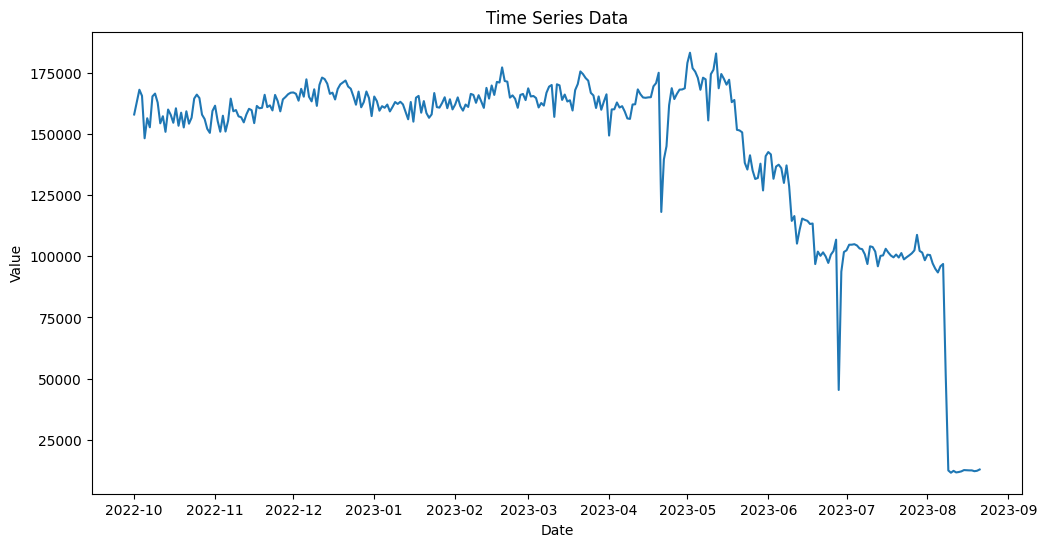

In [10]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['quantity'])
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [11]:
df_grouped.shape

(325, 1)

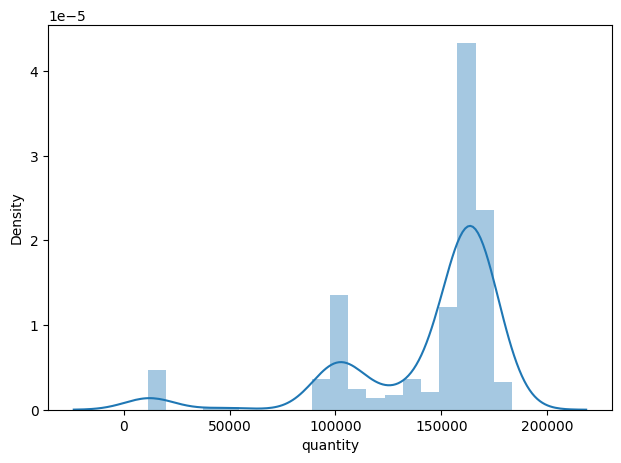

In [12]:
#detecting outlier in Quantity Columns Using Z Score Technique
plt.figure(figsize=(16,5))
plt.subplot(1,2,2)
sns.distplot(df_grouped['quantity'])
plt.show()

In [13]:
df_grouped['quantity'].skew()

-2.0577763783924765

In [14]:
print("Mean vlaue of Quantity", df_grouped['quantity'].mean())
print("Std vlaue of Quantity", df_grouped['quantity'].std())
print("Min vlaue of Quantity", df_grouped['quantity'].min())
print("Max vlaue of Quantity", df_grouped['quantity'].max())

Mean vlaue of Quantity 144310.68307692307
Std vlaue of Quantity 37144.21020551151
Min vlaue of Quantity 11472.0
Max vlaue of Quantity 183324.0


In [15]:
# Finding the boundary values
print("Highest allowed", df_grouped['quantity'].mean() + 3*df_grouped['quantity'].std())
print("Lowest allowed", df_grouped['quantity'].mean() - 3*df_grouped['quantity'].std())

Highest allowed 255743.3136934576
Lowest allowed 32878.05246038854


In [16]:
# Finding the outliers
df_grouped[(df_grouped['quantity'] > 255743.31) | (df_grouped['quantity'] < 32878.05)]

,quantity
everyday,
2023-08-09,12408.0
2023-08-10,11472.0
2023-08-11,12240.0
2023-08-12,11592.0
2023-08-13,11760.0
2023-08-14,12024.0
2023-08-15,12552.0
2023-08-16,12480.0
2023-08-17,12432.0


Approach 1 Trimming

In [17]:
new_df = df_grouped[(df_grouped['quantity'] < 255743.31) & (df_grouped['quantity'] > 32878.05)]
new_df

,quantity
everyday,
2022-10-01,158048.0
2022-10-02,163016.0
2022-10-03,168176.0
2022-10-04,165676.0
2022-10-05,148320.0
...,...
2023-08-04,94944.0
2023-08-05,93408.0
2023-08-06,95952.0


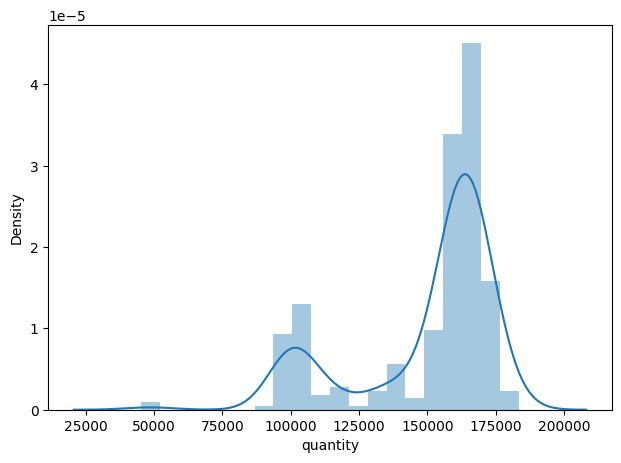

In [18]:
# Plot the time series data
plt.figure(figsize=(16,5))
plt.subplot(1,2,2)
sns.distplot(new_df['quantity'])
plt.show()

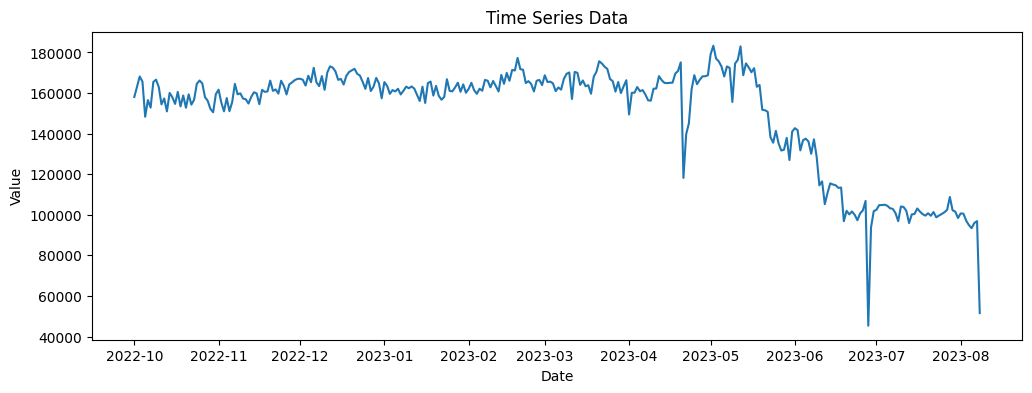

In [19]:
# Plot the time series data
plt.figure(figsize=(12, 4))
plt.plot(new_df['quantity'])
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

Approach 2
#Capping

In [20]:
upper_limit = df_grouped['quantity'].mean() + 3*df_grouped['quantity'].std()
lower_limit = df_grouped['quantity'].mean() - 3*df_grouped['quantity'].std()

In [21]:
upper_limit

255743.3136934576

In [22]:
lower_limit

32878.05246038854

In [23]:
df_grouped['quantity'] = np.where(
    df_grouped['quantity']>upper_limit,
    upper_limit,
    np.where(
        df_grouped['quantity']<lower_limit,
        lower_limit,
        df_grouped['quantity']
    )
)

In [24]:
df_grouped.shape

(325, 1)

In [25]:
df_grouped['quantity'].describe()

count       325.000000
mean     145137.977483
std       34305.869433
min       32878.052460
25%      135528.000000
50%      160796.000000
75%      165864.000000
max      183324.000000
Name: quantity, dtype: float64

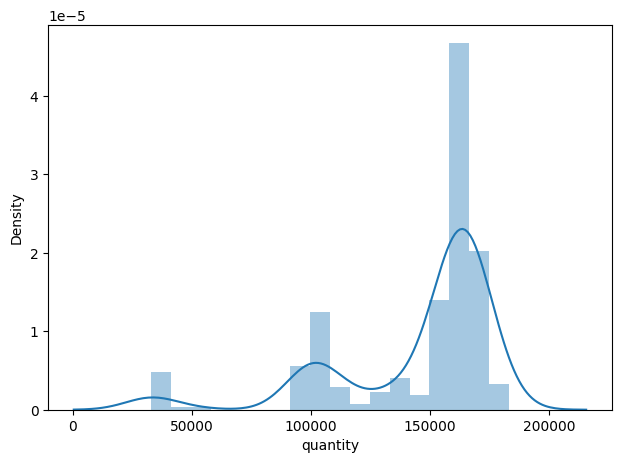

In [26]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,2)
sns.distplot(df_grouped['quantity'])
plt.show()

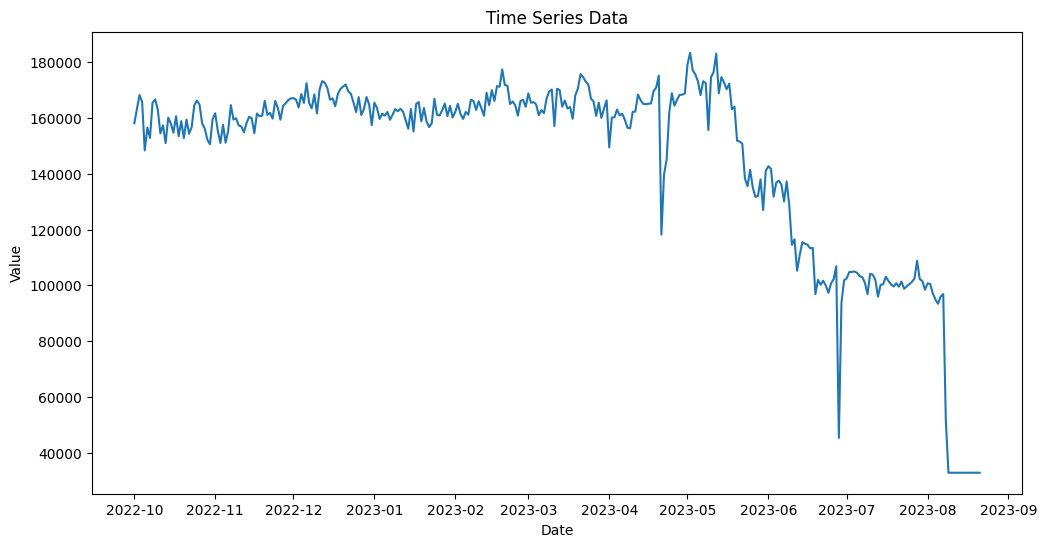

In [27]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['quantity'])
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [28]:
# Try different period values based on assumed seasonality
periods_to_try = [7, 30, 60]  # Daily, monthly, yearly patterns

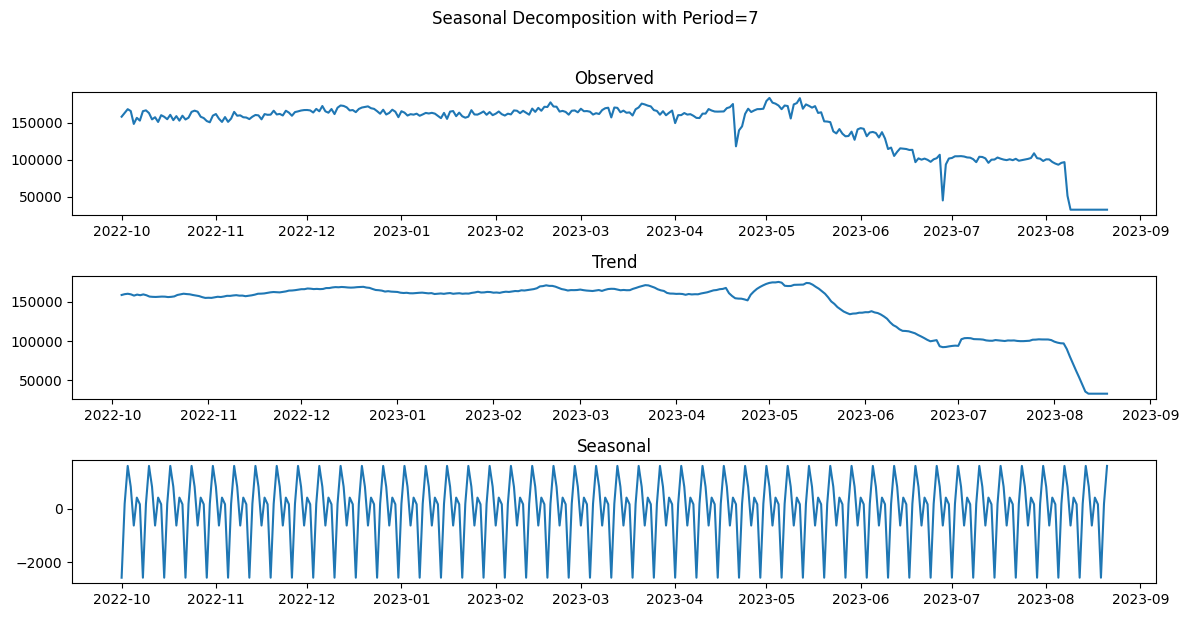

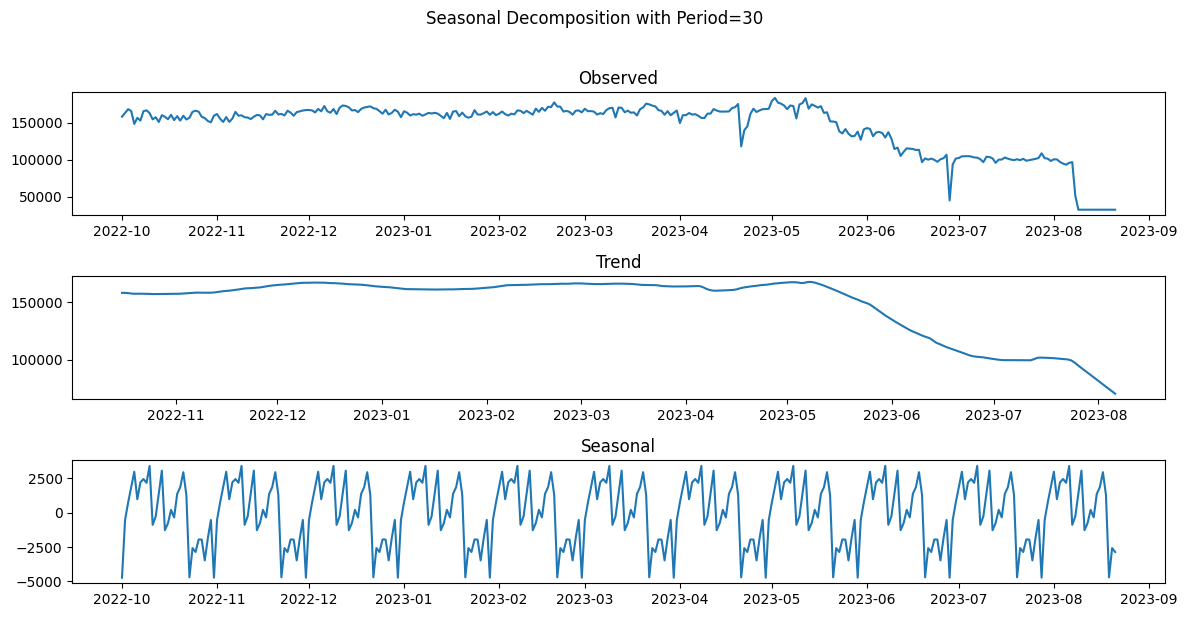

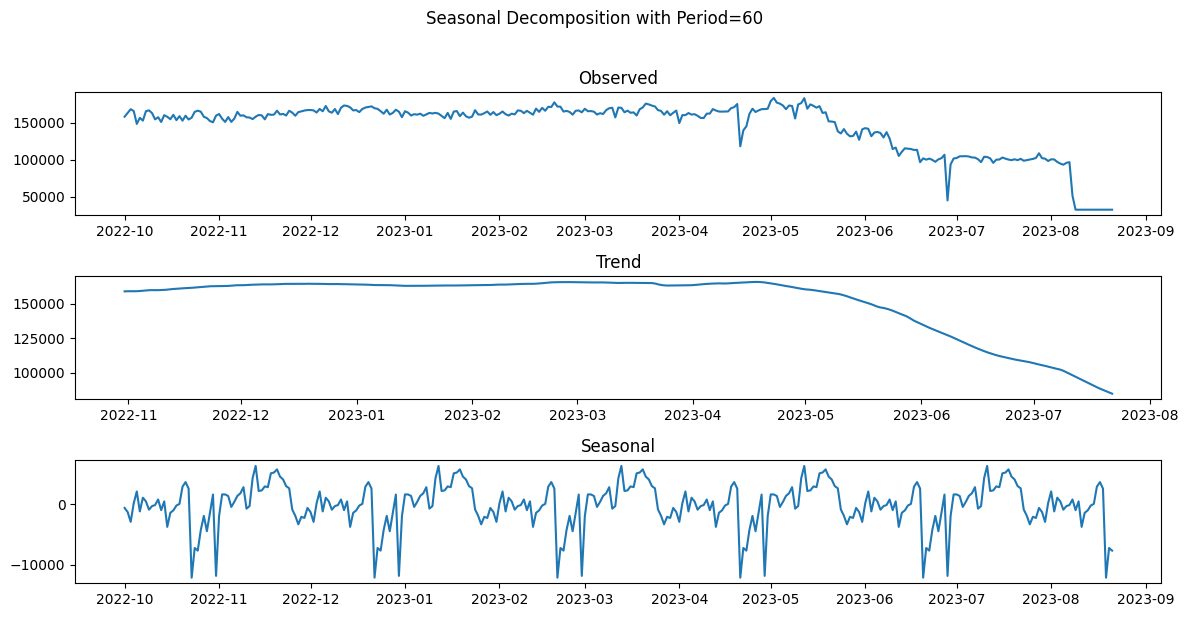

In [29]:
for period_value in periods_to_try:
    result = seasonal_decompose(df_grouped['quantity'], model='additive', period=period_value)
    
    # Plot the decomposed components
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Seasonal Decomposition with Period={period_value}', y=1.02)

    plt.subplot(3, 1, 1)
    plt.plot(result.observed)
    plt.title('Observed')

    plt.subplot(3, 1, 2)
    plt.plot(result.trend)
    plt.title('Trend')

    plt.subplot(3, 1, 3)
    plt.plot(result.seasonal)
    plt.title('Seasonal')

    plt.tight_layout()
    plt.show()

In [30]:
# Testing for Stationarity
from statsmodels.tsa.stattools import adfuller

In [34]:
test_result = adfuller(df_grouped['quantity'])

In [35]:
# H0: It is non stationary
# H1: It is stationary

def adfuller_test(quantity):
    result = adfuller(quantity)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of observations Uesd']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
        if result[1] <= 0.05:
            print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
        else:
            print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

In [36]:
adfuller_test(df_grouped['quantity'])

ADF Test Statistic : 0.8951335951214522
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary
p-value : 0.9930264886669266
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary
#Lags Used : 3
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary
Number of observations Uesd : 321
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


In [37]:
df_grouped['Seasonal First Difference'] = df_grouped['quantity'] - df_grouped['quantity'].shift(12)

In [38]:
df_grouped.head(14)

,quantity,Seasonal First Difference
everyday,,
2022-10-01,158048.0,NaN
2022-10-02,163016.0,NaN
2022-10-03,168176.0,NaN
2022-10-04,165676.0,NaN
2022-10-05,148320.0,NaN
2022-10-06,156516.0,NaN
2022-10-07,152800.0,NaN
2022-10-08,165456.0,NaN
2022-10-09,166600.0,NaN


In [39]:
# Again test dickey fuller test
adfuller_test(df_grouped['Seasonal First Difference'].dropna())

ADF Test Statistic : -2.272017566537534
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary
p-value : 0.18115171855011647
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary
#Lags Used : 13
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary
Number of observations Uesd : 299
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


<Axes: xlabel='everyday'>

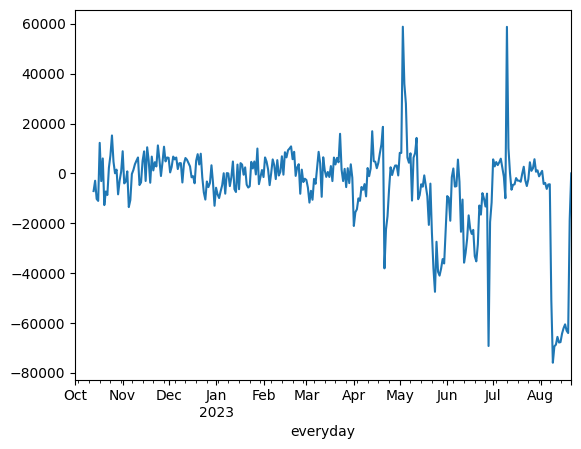

In [40]:
df_grouped['Seasonal First Difference'].plot()

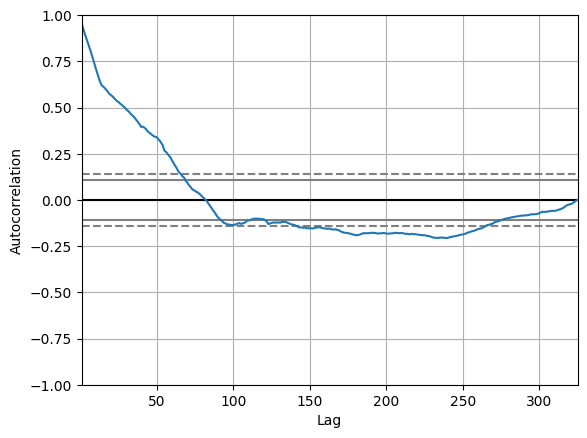

In [41]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_grouped['quantity'])
plt.show()

In [42]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
import statsmodels.api as sm

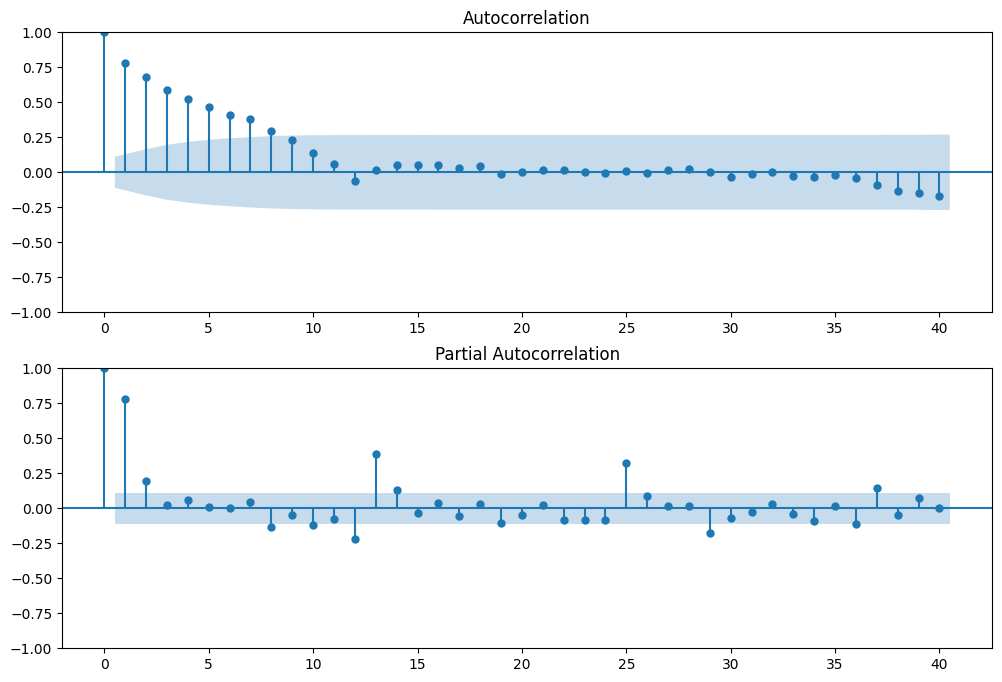

In [43]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_grouped['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_grouped['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [44]:
# for non-seasonal data
#p=1 d=1, q=0
from statsmodels.tsa.arima_model import ARIMA

In [45]:
# Define the order for ARIMA model (p, d, q)
p, d, q = 1, 1, 1

# Create ARIMA model
model = sm.tsa.ARIMA(df_grouped['quantity'], order=(p, d, q))

# Fit the model
model_fit = model.fit()

# Display the summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  325
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3366.160
Date:                Sun, 04 Feb 2024   AIC                           6738.320
Time:                        07:33:38   BIC                           6749.662
Sample:                    10-01-2022   HQIC                          6742.847
                         - 08-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3892      0.155      2.516      0.012       0.086       0.692
ma.L1         -0.5124      0.155     -3.314      0.001      -0.815      -0.209
sigma2      5.696e+07   2.63e-09   2.17e+16      0.0

In [46]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               quantity   No. Observations:                  325
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3366.160
Date:                Sun, 04 Feb 2024   AIC                           6738.320
Time:                        07:33:46   BIC                           6749.662
Sample:                    10-01-2022   HQIC                          6742.847
                         - 08-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3892      0.155      2.516      0.012       0.086       0.692
ma.L1         -0.5124      0.155     -3.314      0.001      -0.815      -0.209
sigma2      5.696e+07   2.63e-09   2.17e+16      0.000     5.7e+07     5.7e+07
===================================================================================
Ljung-Box (L1) (Q):                  10.98   Jarque-Bera (JB):              7368.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.64   Skew:                            -2.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.14e+31. Standard errors may be unstable.
"""

<Axes: xlabel='everyday'>

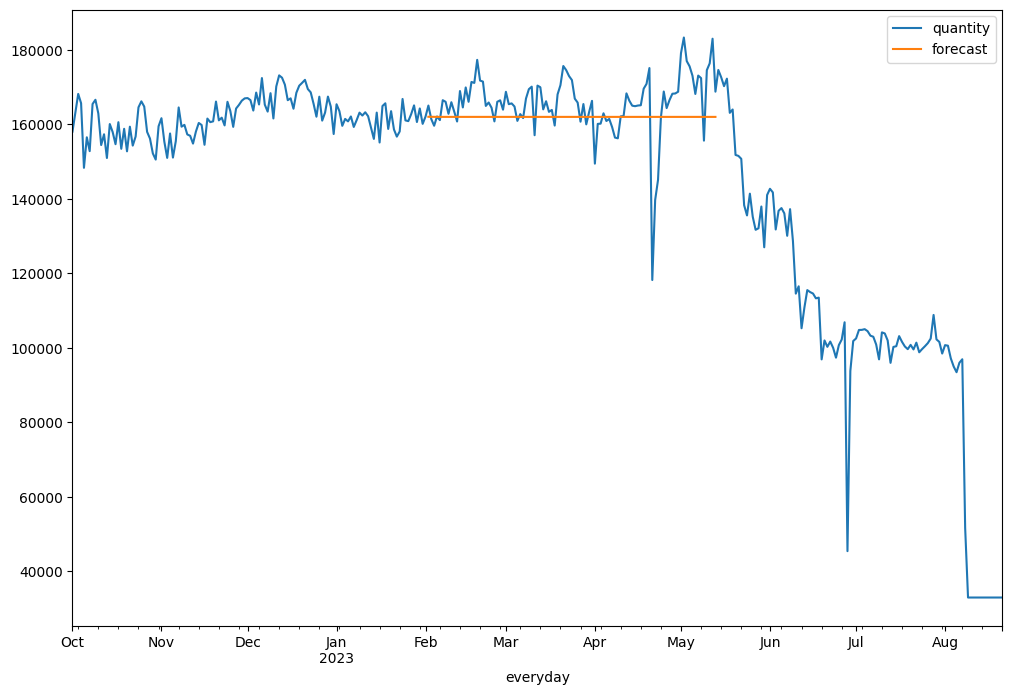

In [47]:
df_grouped['forecast'] = model_fit.predict(start=124,end=224,dynamic=True)
df_grouped[['quantity', 'forecast']].plot(figsize=(12,8))

In [48]:
import statsmodels.api as sm

In [49]:
model=sm.tsa.statespace.SARIMAX(df_grouped['quantity'], order=(1, 1, 1), seasonal_order=(1,1,1,12))
results=model.fit()

<Axes: xlabel='everyday'>

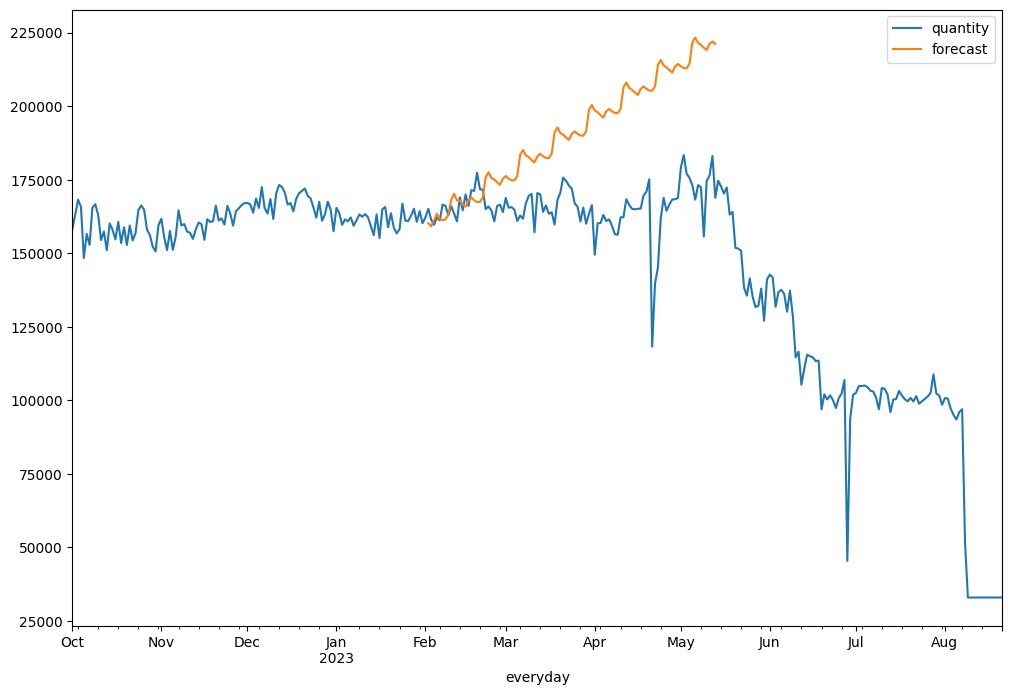

In [50]:
df_grouped['forecast']=results.predict(start=124,end=224,dynamic=True)
df_grouped[['quantity', 'forecast']].plot(figsize=(12,8))